# Dataset

In [99]:
import zipfile

!wget https://chitanka.info/text/4618-frankenshtajn.txt.zip

path = "4618-frankenshtajn.txt.zip"

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(".")
    
!mv "Mary-Shelley -  - . Frankenshtajn - 4618.txt" "dataset.txt"

!rm $path


--2024-09-24 21:52:03--  https://chitanka.info/text/4618-frankenshtajn.txt.zip
Resolving chitanka.info (chitanka.info)... 2a06:98c1:3121::2, 2a06:98c1:3120::2, 188.114.96.2, ...
Connecting to chitanka.info (chitanka.info)|2a06:98c1:3121::2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://m3.chitanka.info/text/4618-frankenshtajn.txt.zip?filename= [following]
--2024-09-24 21:52:04--  https://m3.chitanka.info/text/4618-frankenshtajn.txt.zip?filename=
Resolving m3.chitanka.info (m3.chitanka.info)... 2a06:98c1:3121::2, 2a06:98c1:3120::2, 188.114.97.2, ...
Connecting to m3.chitanka.info (m3.chitanka.info)|2a06:98c1:3121::2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /cache/dl/Mary-Shelley_-_Frankenshtajn_-_4618.txt.zip [following]
--2024-09-24 21:52:04--  https://m3.chitanka.info/cache/dl/Mary-Shelley_-_Frankenshtajn_-_4618.txt.zip
Reusing existing connection to [m3.chitanka.info]:443.
HTTP request sent, awaiting respon

In [100]:
with open("dataset.txt", "r") as f:
    text = f.read()

# Vocabulary

In [101]:
unique_chars = set(text)
sorted_chars = sorted(unique_chars)
sorted_chars
"".join(sorted_chars)

'\t\n !$()*,-./0123456789:;=?DIMNVX[]_abcdefghijkmnoprstuvx«»АБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЮЯабвгдежзийклмнопрстуфхцчшщъьюя–—“„…\ufeff'

# Tokenizer

In [102]:
encoding = { c: i for i, c in enumerate(sorted_chars) }

def encode(text: str):
    return [encoding[c] for c in text]

def test_encode():
    test_text = "франкейщайн!"
    test_encoding = encode(test_text)
    assert test_encoding[0] == encoding[test_text[0]]
    assert test_encoding[1] == encoding[test_text[1]]
    
# test_encode()

decoding = { i: c for i, c in enumerate(sorted_chars) }

test_text = "франкейщайн!"
test_encoding = encode(test_text)

def decode(arr):
    return "".join([decoding[t] for t in arr])

def test_decode():
    test_text = "франкейщайн!"
    assert decode(encode(test_text)) == test_text
    
# test_decode()

In [103]:
import torch

data = torch.tensor(encode(text))

data

tensor([120,   0,  69,  ...,  13,   1,   1])

In [104]:
train_data_size = round(len(data) * 0.9)

train_data = data[:train_data_size]

train_data

tensor([120,   0,  69,  ..., 102,  95,  99])

In [105]:
val_data = data[train_data_size:]

val_data

tensor([103,  99,   2,  ...,  13,   1,   1])

# Model input and output (output = input[last + 1])

In [106]:
context_length = 8

train_data[:context_length+1]

tensor([120,   0,  69,  90, 101,  93,   2,  81,  90])

In [107]:
model_input = train_data[:context_length]

model_input

tensor([120,   0,  69,  90, 101,  93,   2,  81])

In [108]:
decode(model_input.numpy().tolist())

'\ufeff\tМери Ш'

In [109]:
model_output = train_data[1:context_length+1]

model_output[-1]

tensor(90)

In [110]:
decode(model_output.numpy().tolist())[-1]

'е'

# Batch

In [111]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def get_batch(split: str, batch_size: int, context_length: int):
    batch_data = train_data if split == "train" else val_data
    ix = torch.randint(len(batch_data) - context_length, (batch_size,))

    x = torch.stack([batch_data[i:i+context_length] for i in ix])
        
    y = torch.stack([batch_data[i+1:i+context_length+1] for i in ix])
    
    x, y = x.to(device), y.to(device)
    
    return x, y

# Log loss

In [112]:
@torch.no_grad()
def estimate_loss(model, iterations, batch_size, context_length):
    estimation = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(iterations)
        for k in range(iterations):
            X, Y = get_batch(split, batch_size, context_length)
            X, Y = X.to(device), Y.to(device)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        estimation[split] = losses.mean()
    model.train()
    return estimation

# Bigram model

In [113]:
import torch.nn as nn
import torch.nn.functional as F

vocabulary_size = len(sorted_chars) # unique chars in dataset

class BigramModel(nn.Module):
    def __init__(self, vocabulary_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocabulary_size, vocabulary_size)
        
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx) # returns (batch, time, channel) = (batch_size, context_length, vocabulary_size)
        
        if targets is None:
            loss = None
        else:        
            batch, time, channel = logits.shape
            
            logits = logits.view(batch * time, channel)
            targets = targets.view(batch * time)
            
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (batch_size, context_length) array of indices in the current context
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :] # becomes (batch_size, channel)

            probs = F.softmax(logits, dim=-1) # (batch_size, channel)
            
            next_idx = torch.multinomial(probs, num_samples=1) # (batch_size, 1)
            
            idx = torch.cat((idx, next_idx), dim=1) # (batch_size, context_length + 1)
        return idx
    
m = BigramModel(vocabulary_size)

bigram_model = m.to(device)

idx = torch.zeros((1, 1), dtype=torch.long, device=device)

generated = bigram_model.generate(idx, max_new_tokens=100)[0].tolist()

print(decode(generated)) # ~ random generation, model not trained

	яоЯV6i3“1З	 ОГt2т;“П-КN831„)мУ9мбъIц0?fгuЦ5r	1cVСзЗРетчЦФньф»Фaшрes)тмpшнeЩXмЩаt_ЧГКМО2Лууc„69тс7„Рn


# Bigram model training

In [114]:
vocabulary_size = len(sorted_chars) # unique chars in dataset
n_embeddings = 384
n_heads = 6
n_layers = 6
max_iterations = 5000
iterations_interval = 100
eval_iterations = 200
batch_size = 64
learning_rate = 1e-4
context_length = 256
dropout = 0.2

def train_model(max_iterations=max_iterations, iterations_interval=iterations_interval, eval_iterations=eval_iterations, batch_size=batch_size, learning_rate=learning_rate, context_length=context_length, model=bigram_model):
    train_losses = []
    val_losses = []
    steps = []

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for iteration in range(max_iterations):
        if iteration % iterations_interval == 0:
            losses = estimate_loss(model, eval_iterations, batch_size, context_length)
            print(f"step {iteration}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])
            steps.append(iteration)
            
        xb, yb = get_batch("train", batch_size, context_length)
        
        _, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
    return train_losses, val_losses, steps

step 0: train loss 5.3175, val loss 5.3072
step 100: train loss 5.1534, val loss 5.1418
step 200: train loss 4.9948, val loss 4.9839
step 300: train loss 4.8417, val loss 4.8290
step 400: train loss 4.6932, val loss 4.6820
step 500: train loss 4.5520, val loss 4.5415
step 600: train loss 4.4147, val loss 4.4055
step 700: train loss 4.2863, val loss 4.2771
step 800: train loss 4.1630, val loss 4.1525
step 900: train loss 4.0460, val loss 4.0365
step 1000: train loss 3.9360, val loss 3.9277
step 1100: train loss 3.8311, val loss 3.8231
step 1200: train loss 3.7316, val loss 3.7228
step 1300: train loss 3.6398, val loss 3.6295
step 1400: train loss 3.5495, val loss 3.5421
step 1500: train loss 3.4687, val loss 3.4608
step 1600: train loss 3.3911, val loss 3.3835
step 1700: train loss 3.3184, val loss 3.3096
step 1800: train loss 3.2524, val loss 3.2455
step 1900: train loss 3.1862, val loss 3.1812
step 2000: train loss 3.1290, val loss 3.1229
step 2100: train loss 3.0750, val loss 3.0670


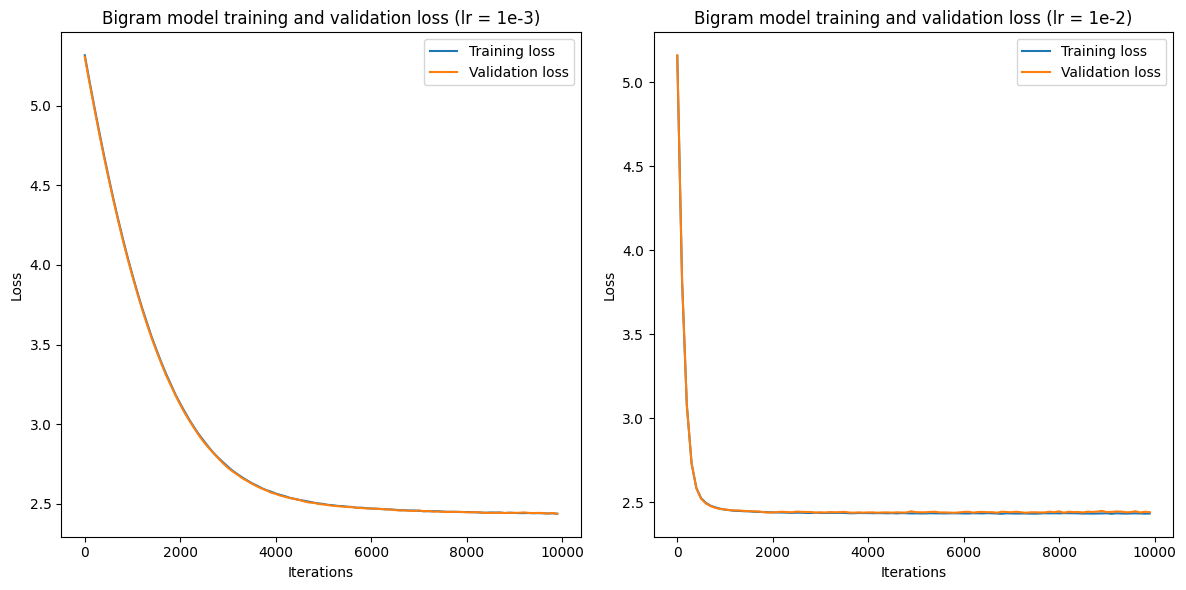

In [115]:
import matplotlib.pyplot as plt

train_losses, val_losses, steps = train_model(model=bigram_model, learning_rate=1e-3, batch_size=32, max_iterations=10000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(steps, train_losses, label="Training loss")
ax1.plot(steps, val_losses, label="Validation loss")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.set_title("Bigram model training and validation loss (lr = 1e-3)")
ax1.legend()

m = BigramModel(vocabulary_size)

bigram_model = m.to(device)

train_losses, val_losses, steps = train_model(learning_rate=1e-2, model=bigram_model, batch_size=32, max_iterations=10000)

ax2.plot(steps, train_losses, label="Training loss")
ax2.plot(steps, val_losses, label="Validation loss")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")
ax2.set_title("Bigram model training and validation loss (lr = 1e-2)")
ax2.legend()
plt.tight_layout()
plt.show()

In [116]:
idx = torch.zeros((1, 1), dtype=torch.long, device=device)

generated = bigram_model.generate(idx, max_new_tokens=300)[0].tolist()

print(decode(generated))

	Гни тниеснеднемо лдре сало тороса пой,
	Изеби игазати та дичкъми оберитижина с осво побратълюци продедерявли ли прапри Канощалми мни. рхарах.
	— знакитеноя плост доз на ми, нията то иера пра о, пито слиста млиздри ме ве ре, пувакт Иматизполода поствичучесъза Б. сл бях таназговакотемя. бро св е уд ка


# Self-attention

Current tokens should get information only from previous tokens (not future ones)

Inefficient way of computing

In [117]:
import torch

batch, time, channel = 4, 8, 2
x = torch.randn(batch, time, channel)
x.shape

torch.Size([4, 8, 2])

In [118]:
 # x[b, t] = mean_{i <= t} x[b, i]
 
x_bag_of_words = torch.zeros(batch, time, channel)

for b in range(batch):
    for t in range(time):
        x_previous = x[b, :t+1] # (time, channel)
        x_bag_of_words[b, t] = torch.mean(x_previous, 0)
        
# x[0] equals x_bag_of_words[0] but x[1] does not equal x_bag_of_words[1]
# because x_bag_of_words[1] is the average of [x0] and x[1]

In [119]:
x[0]

tensor([[-0.3680,  0.6571],
        [ 1.5808,  0.2900],
        [-0.2151,  2.4736],
        [ 0.2295, -0.3849],
        [ 0.0560,  0.3504],
        [ 0.5029,  0.0656],
        [ 0.8499, -1.7485],
        [-0.3152,  0.4329]])

In [120]:
x_bag_of_words[0]

tensor([[-0.3680,  0.6571],
        [ 0.6064,  0.4736],
        [ 0.3326,  1.1403],
        [ 0.3068,  0.7590],
        [ 0.2567,  0.6773],
        [ 0.2977,  0.5753],
        [ 0.3766,  0.2433],
        [ 0.2901,  0.2670]])

Computing using matrix multiplication (weighted aggregation)

In [121]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3)) # [[1., 0., 0.], [1., 1., 0.], [1., 1., 1.]]
a = a / torch.sum(a, 1, keepdim=True) # dividing by [[1.], [2.], [3.]], a becomes [[1., 0., 0.], [0.5, 0.5, 0.], [0.33, 0.33, 0.33]]
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

# again each row in C is the average of the previous

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [122]:
weighted_aggregation = torch.tril(torch.ones(time, time))
weighted_aggregation = weighted_aggregation / weighted_aggregation.sum(1, keepdim=True)

x_bag_of_words_wei = weighted_aggregation @ x # (batch, time, time) @ (batch, time, channel) ----> (batch, time, channel)
torch.allclose(x_bag_of_words, x_bag_of_words_wei)

True

Computing using softmax (normalization)

In [123]:
import torch.nn.functional as F

tril = torch.tril(torch.ones(time, time))
weighted_aggregation = torch.zeros((time, time))
weighted_aggregation = weighted_aggregation.masked_fill(tril == 0, float('-inf')) # make all 0 tril elements = -inf so softmax returns 0 for them (because shouldn't get information from past tokens)
weighted_aggregation = F.softmax(weighted_aggregation, dim=-1) # normalization
x_bag_of_words_softmax = weighted_aggregation @ x # aggregation
torch.allclose(x_bag_of_words, x_bag_of_words_softmax)

True

# Generative pretrained transformer

In [124]:
class Head(nn.Module):
    def __init__(self, head_size, n_embeddings, context_length, dropout):
        super().__init__()
        self.key = nn.Linear(n_embeddings, head_size, bias=False)
        self.query = nn.Linear(n_embeddings, head_size, bias=False)
        self.value = nn.Linear(n_embeddings, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        batch_size, context_length, channel = x.shape
        k = self.key(x) # (batch_size, context_length, channel)
        q = self.query(x) # (batch_size, context_length, channel)
        # attention scores ("affinities")
        weighted_aggregation = q @ k.transpose(-2,-1) * channel**-0.5 # (batch_size, context_length, channel) @ (batch_size, channel, context_length) -> (batch_size, context_length, context_length)
        weighted_aggregation = weighted_aggregation.masked_fill(self.tril[:context_length, :context_length] == 0, float('-inf')) # (batch_size, context_length, context_length)
        weighted_aggregation = F.softmax(weighted_aggregation, dim=-1) # (batch_size, context_length, context_length)
        weighted_aggregation = self.dropout(weighted_aggregation)
        # weighted aggregation of the values
        v = self.value(x) # (batch_size, context_length, channel)
        return weighted_aggregation @ v # (batch_size, context_length, context_length) @  (batch_size, context_length, channel) ->  (batch_size, context_length, channel)

In [125]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embeddings, context_length, dropout):
        super(
            ).__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embeddings, context_length, dropout) for _ in range(num_heads)])
        self.projection = nn.Linear(n_embeddings, n_embeddings)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.projection(torch.cat([h(x) for h in self.heads], dim=-1)))

In [126]:
class FeedForward(nn.Module):
    def __init__(self, n_embeddings, dropout):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(n_embeddings, 4 * n_embeddings),
            nn.ReLU(),
            nn.Linear(4 * n_embeddings, n_embeddings),
            nn.Dropout(dropout)
        )
        
        
    def forward(self, x):
        return self.network(x)

In [127]:
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, n_embeddings, n_heads, context_length, dropout):
        super().__init__()
        head_size = n_embeddings // n_heads
        self.self_attention = MultiHeadAttention(n_heads, head_size, n_embeddings, context_length, dropout)
        self.feed_forward = FeedForward(n_embeddings, dropout)
        self.layer_normalization_self_attention = nn.LayerNorm(n_embeddings)
        self.layer_normalization_feed_forward = nn.LayerNorm(n_embeddings)
        
        
    def forward(self, x):
        x = x + self.self_attention(self.layer_normalization_self_attention(x))
        return x + self.feed_forward(self.layer_normalization_feed_forward(x))

In [130]:
import torch.nn.functional as F

class GPT(nn.Module):
    def __init__(self, vocabulary_size, n_embeddings, n_heads, context_length, n_layers, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocabulary_size, n_embeddings)
        self.position_embedding_table = nn.Embedding(context_length, n_embeddings) # positions at which the tokens occur
        self.blocks = nn.Sequential(*[Block(n_embeddings, n_heads, context_length, dropout) for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(n_embeddings)
        self.lm_head = nn.Linear(n_embeddings, vocabulary_size)
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, idx, targets=None):
        batch_size, context_length = idx.shape
        
        token_embedding = self.token_embedding_table(idx) # returns (batch, time, channel) = (batch_size, context_length, vocabulary_size)
        position_embedding = self.position_embedding_table(torch.arange(context_length, device=device)) # (context_size, channel)
        x = token_embedding + position_embedding # (batch_size, context_length, channel) - information for both tokens' identities and their positions                                                   
        x = self.blocks(x)
        x = self.layer_norm(x)
        logits = self.lm_head(x) # (batch, context_length, vocabulary_size)
        
        if targets is None:
            loss = None
        else:        
            batch, time, channel = logits.shape
            
            logits = logits.view(batch * time, channel)
            targets = targets.view(batch * time)
            
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (batch_size, context_length) array of indices in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_length:] # crop context
            
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # becomes (batch_size, channel)

            probs = F.softmax(logits, dim=-1) # (batch_size, channel)
            
            next_idx = torch.multinomial(probs, num_samples=1) # (batch_size, 1)
            
            idx = torch.cat((idx, next_idx), dim=1) # (batch_size, context_length + 1)
        return idx

In [133]:
m = GPT(vocabulary_size, n_embeddings, n_heads, context_length, n_layers, dropout)

gpt_model = m.to(device)

learning_rate = 3e-4

train_losses, val_losses, steps = train_model(model=gpt_model, learning_rate=learning_rate, max_iterations=2000)

step 0: train loss 4.9466, val loss 4.9448
step 100: train loss 2.4695, val loss 2.4678
step 200: train loss 2.4223, val loss 2.4205
step 300: train loss 2.3757, val loss 2.3729
step 400: train loss 2.2951, val loss 2.2898
step 500: train loss 2.0606, val loss 2.0622
step 600: train loss 1.8170, val loss 1.8362
step 700: train loss 1.6322, val loss 1.6815
step 800: train loss 1.5142, val loss 1.5954
step 900: train loss 1.4155, val loss 1.5259
step 1000: train loss 1.3416, val loss 1.4884
step 1100: train loss 1.2761, val loss 1.4542
step 1200: train loss 1.2189, val loss 1.4385
step 1300: train loss 1.1669, val loss 1.4174
step 1400: train loss 1.1123, val loss 1.4039
step 1500: train loss 1.0702, val loss 1.4170
step 1600: train loss 1.0237, val loss 1.4085
step 1700: train loss 0.9784, val loss 1.4229
step 1800: train loss 0.9297, val loss 1.4280
step 1900: train loss 0.8848, val loss 1.4371


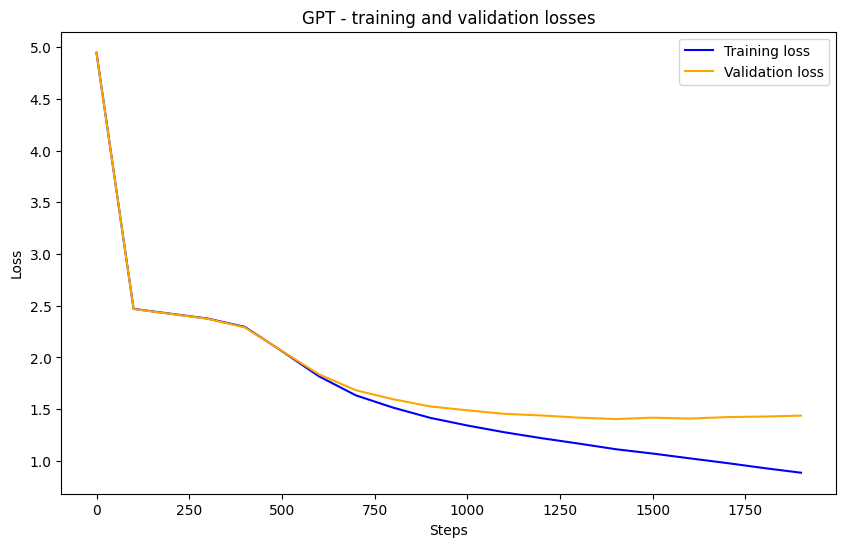

In [134]:
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Training loss', color='blue')
plt.plot(steps, val_losses, label='Validation loss', color='orange')
plt.title('GPT - training and validation losses')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [135]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(gpt_model.generate(context, max_new_tokens=500)[0].tolist()))

	Да пришекоя обеданието на сведените, не съм кълнени, незатсъпилодение около еподростровчетво на всеки нования цвечешки пол градски, съществяваше само ме от погледа. С укритието можеше да разберат си месецът от същото се смери имаение, че когато бяха му освен плесен край на нещата и аз тяхната се отличаше трудно: насле дългия ми прокливи хразвалите имаха мъчите на създадените аз силния преди да дивят ти (когато само отношени да вдъхна така; следца се грижа, разбирам мъка и Елизабет писва молбата 
